# 构造与地质单元交汇分析 (Intersection Analysis)

本 Notebook 目的：

- 读取结构图层与地质图层。
- 进行空间叠加 / 相交分析。
- 以shp格式输出交叉结果供后续制图或深入统计。
- 生成可视化。

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# 1. 加载地质数据
structure_shp_path = '../resources/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Structure.shp'
geology_shp_path = '../resources/SIM3292_MarsGlobalGeologicGIS_20M/SIM3292_Shapefiles/SIM3292_Global_Geology.shp'
structure_gdf = gpd.read_file(structure_shp_path)
geology_gdf = gpd.read_file(geology_shp_path)

print(f"地质单元：{len(geology_gdf)} 个地质单元")
print(f"结构数据：{len(structure_gdf)} 条结构线")

地质单元：1311 个地质单元
结构数据：3593 条结构线


In [3]:
# 2. 确保两个数据集使用相同的坐标系
if structure_gdf.crs != geology_gdf.crs:
    print(f"坐标系不匹配: structure={structure_gdf.crs}, geology={geology_gdf.crs}")
    print("正在将structure数据转换为geology的坐标系...")
    structure_gdf = structure_gdf.to_crs(geology_gdf.crs)
    print("坐标系转换完成")
else:
    print("坐标系匹配")

print(f"最终坐标系: {structure_gdf.crs}")

坐标系匹配
最终坐标系: GEOGCS["GCS_Mars_2000_Sphere",DATUM["Mars_2000_(Sphere)",SPHEROID["Mars_2000_Sphere_IAU_IAG",3396190,0],AUTHORITY["ESRI","106971"]],PRIMEM["Reference_Meridian",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [4]:
# 3. 执行空间相交分析（Spatial Overlay）
# 使用 intersect 来找到每条结构线与哪些地质多边形相交
intersection_result = gpd.overlay(structure_gdf, geology_gdf, how='intersection', keep_geom_type=True)

print(f"相交分析完成：找到 {len(intersection_result)} 个相交记录")

相交分析完成：找到 5192 个相交记录


In [5]:
# 4. 为每条原始结构线聚合所有相交的地质单元及其长度

# 创建字典来存储每个OBJECTID对应的地质单元和长度
structure_geology_length_dict = defaultdict(dict)

# 遍历相交结果，收集每条结构线经过的所有地质单元及其长度
for _, row in intersection_result.iterrows():
    structure_id = row['OBJECTID_1']  # 结构线的ID
    geology_unit = row['Unit']        # 地质单元
    
    # 计算这段相交几何体的长度
    intersection_length = row.geometry.length
    
    # 累积该结构线在这个地质单元中的总长度
    if geology_unit in structure_geology_length_dict[structure_id]:
        structure_geology_length_dict[structure_id][geology_unit] += intersection_length
    else:
        structure_geology_length_dict[structure_id][geology_unit] = intersection_length

In [6]:
# 5. 为原始结构数据添加新字段
def get_geology_units(objectid):
    """获取指定结构线经过的所有地质单元"""
    unit_lengths = structure_geology_length_dict.get(objectid, {})
    if unit_lengths:
        return ', '.join(sorted(unit_lengths.keys()))  # 以逗号分隔的字符串形式返回
    else:
        return 'No intersection'  # 没有相交的情况

def get_geology_units_count(objectid):
    """获取指定结构线经过的地质单元数量"""
    unit_lengths = structure_geology_length_dict.get(objectid, {})
    return len(unit_lengths)

def get_longest_geology_unit(objectid):
    """获取指定结构线经过最长的地质单元"""
    unit_lengths = structure_geology_length_dict.get(objectid, {})
    if unit_lengths:
        # 找到长度最大的地质单元
        longest_unit = max(unit_lengths.items(), key=lambda x: x[1])
        return longest_unit[0]  # 返回地质单元名称
    else:
        return 'No intersection'

def get_longest_unit_length(objectid):
    """获取指定结构线在最长地质单元中的长度"""
    unit_lengths = structure_geology_length_dict.get(objectid, {})
    if unit_lengths:
        # 找到最大长度
        longest_length = max(unit_lengths.values())
        return round(longest_length, 2)  # 保留两位小数
    else:
        return 0.0
    
def get_total_length(objectid):
    """获取指定结构线的总长度"""
    unit_lengths = structure_geology_length_dict.get(objectid, {})
    return round(sum(unit_lengths.values()), 2)  # 保留两位小数

# 添加新字段
structure_gdf['Units'] = structure_gdf['OBJECTID'].apply(get_geology_units)
structure_gdf['Units_Num'] = structure_gdf['OBJECTID'].apply(get_geology_units_count)
structure_gdf['Unit'] = structure_gdf['OBJECTID'].apply(get_longest_geology_unit)
structure_gdf['Unit_Leng'] = structure_gdf['OBJECTID'].apply(get_longest_unit_length)
structure_gdf['Total_Leng'] = structure_gdf['OBJECTID'].apply(get_total_length)

In [7]:
# 6. 查看结果统计
print("\n=== 结果统计 ===")
print("经过地质单元数量的分布：")
print(structure_gdf['Units_Num'].value_counts().sort_index())

print("\n前10条结构线的地质单元信息：")
columns_to_show = ['OBJECTID', 'Unit', 'Unit_Leng', 'Total_Leng', 'Units_Num', 'Units']
structure_gdf[columns_to_show].head(10)


=== 结果统计 ===
经过地质单元数量的分布：
Units_Num
1    2332
2    1042
3     185
4      30
5       3
7       1
Name: count, dtype: int64

前10条结构线的地质单元信息：


,OBJECTID,Unit,Unit_Leng,Total_Leng,Units_Num,Units
0,1,lNh,6.53,16.18,3,"lNh, mNh, mNhm"
1,2,mNhm,1.55,2.41,2,"AHi, mNhm"
2,3,AHi,2.92,2.92,1,AHi
3,4,mNhm,3.72,3.74,2,"HNb, mNhm"
4,5,mNhm,2.22,2.22,1,mNhm
5,6,mNhm,5.65,5.65,1,mNhm
6,7,mNhm,5.26,5.26,1,mNhm
7,8,mNhm,6.14,6.14,1,mNhm
8,9,mNhm,3.29,3.29,1,mNhm
9,10,mNhm,2.71,2.71,1,mNhm


In [8]:
# 7. 保存增强后的数据到新的shapefile
output_path = '../output/shapfiles/SIM3292_Global_Structure_Expanded.shp'
structure_gdf.to_file(output_path)
print(f"结构数据已保存到：{output_path}")

# 显示保存的字段信息
print(f"\n保存的字段包括：")
for col in structure_gdf.columns:
    if col != 'geometry':
        print(f"  - {col}: {structure_gdf[col].dtype}")

print(f"\n新增字段说明：")
print(f"  - Unit: 结构线经过的主要地质单元")
print(f"  - Unit_Leng: 结构线在最长地质单元中的长度")
print(f"  - Total_Leng: 结构线的总长度")
print(f"  - Units: 结构线经过的所有地质单元（逗号分隔）")
print(f"  - Units_Num: 结构线经过的地质单元数量")

结构数据已保存到：../output/shapfiles/SIM3292_Global_Structure_Expanded.shp

保存的字段包括：
  - OBJECTID: int32
  - Morphology: object
  - Origin: object
  - Interpreta: object
  - Preservati: object
  - Dimension: object
  - Shape_Leng: float64
  - SphLen_km: float64
  - Units: object
  - Units_Num: int64
  - Unit: object
  - Unit_Leng: float64
  - Total_Leng: float64

新增字段说明：
  - Unit: 结构线经过的主要地质单元
  - Unit_Leng: 结构线在最长地质单元中的长度
  - Total_Leng: 结构线的总长度
  - Units: 结构线经过的所有地质单元（逗号分隔）
  - Units_Num: 结构线经过的地质单元数量


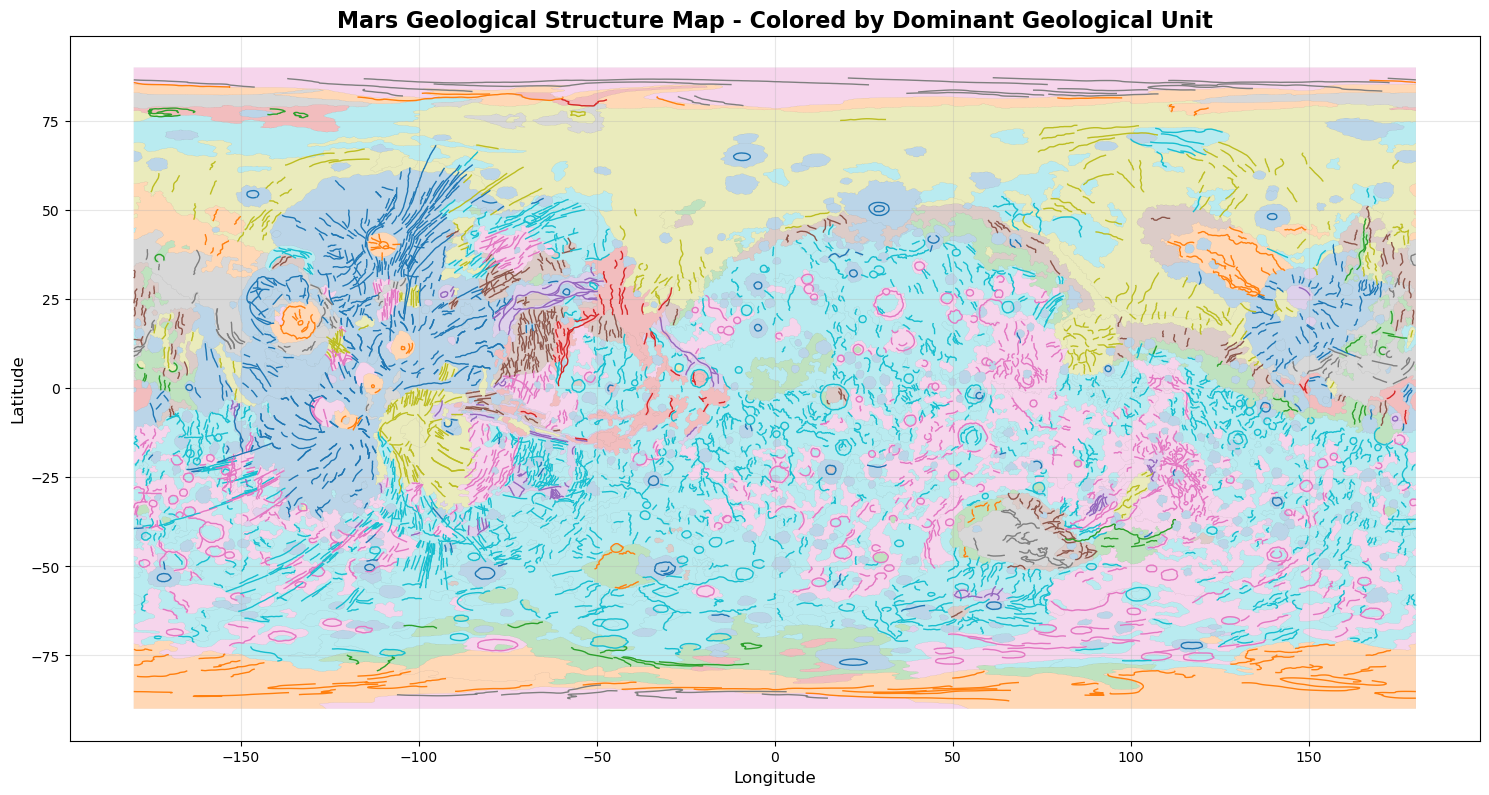


=== Chart Statistics ===
Valid structure lines: 3593
No intersection lines: 0


In [ ]:
# 8. 创建可视化图表 - 按经过的主要地质单元着色的结构线
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# 绘制地质单元作为底图
geology_gdf.plot(column='Unit', categorical=True, legend=False, ax=ax, 
                edgecolor='black', linewidth=0.05, alpha=0.3)

# 获取有效的最长地质单元（排除'No intersection'）
valid_structure_gdf = structure_gdf[structure_gdf['Unit'] != 'No intersection'].copy()

if len(valid_structure_gdf) > 0:
    # 按最长地质单元着色的结构线
    valid_structure_gdf.plot(ax=ax, column='Unit', categorical=True, linewidth=1.0,
                            legend=False)

# 设置标题和标签
ax.set_title('Mars Geological Structure Map - Colored by Dominant Geological Unit', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.grid(True, alpha=0.3)

# 调整布局以适应图例
plt.tight_layout()
plt.show()

# 显示统计信息
print(f"\n=== 信息统计 ===")
print(f"有效结构线数量: {len(valid_structure_gdf)}")
print(f"无交叉结构线数量: {len(structure_gdf) - len(valid_structure_gdf)}")